<a href="https://colab.research.google.com/github/anathayna/tcc/blob/main/tcc_zero_shot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="orange">**TCC: Classificação do discurso de ódio em memes (zero-shot)**</font>

O Google Colab é uma plataforma baseada em Jupyter Notebook que oferece um ambiente de execução em nuvem com recursos gratuitos de GPU e TPU, amplamente utilizado em projetos de aprendizado de máquina e ciência de dados.

Este notebook documenta as etapas iniciais do trabalho de conclusão de curso, cujo objetivo é classificar discursos de ódio em memes por meio de técnicas de aprendizado de máquina multimodal.

No primeiro experimento, foi realizada uma classificação binária simples, utilizando os prompts:

- “isso é ódio”

- “isso não é ódio”

Essa etapa tem como finalidade estabelecer uma linha de base para a tarefa de detecção automática de discurso de ódio em memes, servindo como ponto de partida para experimentos mais complexos.

# <font color="orange">**Sumário**</font>

1.   Instalando bibliotecas e dependências
2.   Preparando o banco de dados
3.   Pré-processamento
4.   Classificação
5.   Avaliação
6.   Conclusão

## <font color="orange">1. Instalando bibliotecas e dependências</font>

Primeiro, configure o ambiente de execução do Google Colab para o GPU T4, que é voltado para aceleração de inferência de modelos de aprendizado profundo.

Outro detalhe que o Google Colab já vem com CUDA pré-instalado e drivers de GPU.

O **CUDA** (Compute Unified Device Architecture) é uma plataforma de computação paralela desenvolvida pela NVIDIA para acelerar processamentos usando GPUs (Graphics Processing Units). Ele permite que programas utilizem o poder de processamento massivamente paralelo das GPUs.

In [ ]:
!nvcc --version  # Verifica se o CUDA está disponível
!nvidia-smi  # Mostra detalhes da GPU (como versão suportada)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
Wed Oct 22 18:34:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8       

Próximo passo é conferir se o PyTorch 1.7.1 (ou uma versão superior) e o torchvision estão instalados.

In [ ]:
import torch
import torchvision
import numpy as np
import torch
from pkg_resources import packaging

print("Versão do Torch:", torch.__version__)
print("Versão do Torchvision:", torchvision.__version__)

Versão do Torch: 2.8.0+cu126
Versão do Torchvision: 0.23.0+cu126


/tmp/ipython-input-564720634.py:5: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging


Após conferir as instalações iniciais, serão instaladas as seguintes dependências: o pacote *ftfy* (para normalização de texto), a biblioteca *regex* (processamento de strings) e *tqdm* (monitoramento de progresso).

In [ ]:
!pip install ftfy regex tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.2 MB/s eta 0:00:00


In [ ]:
!pip install googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.7 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17396 sha256=ce24ecf4d4164cc7c6a924f8b34ac08b2ef19dde5915998306d62bb4e184dfba
  Stored in directory: /root/.cache/pip/wheels/95/0f/04/b17a72024b56a60e499ce1a6313d283ed5ba332407155bee03
Successfully built googletrans
  Attempting uninstall: hyperframe
    Found existing installation: hyperframe 6.1.0
    Uninstalling hyperfram

Essas instalações são pré-requisito para a execução do modelo CLIP (Contrastive Language–Image Pretraining) da OpenAI, que será a metodologia central deste trabalho. Em seguida, será feito a instalação do CLIP por meio de sua implementação oficial disponível no GitHub.

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-tdasim1h
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-tdasim1h
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=82d524156d085ddf3acf5353b594848845a58ee8689eae66217d69b73fca8e95
  Stored in directory: /tmp/pip-ephem-wheel-cache-j_ih6ah0/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


O CLIP fornece os seguintes modelos:

In [ ]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

*   **ViT-B/32**: mais rápido e leve
*   **ViT-L/14**: tem maior precisão e alcança melhores resultados, mas exigem mais GPU
*   **ViT-B/16**: equilíbrio entre velocidade e acurácia



Tais modelos permitem analisar e extrair propriedades relevantes para seu uso, como o **ViT-B/32** que é o mais utilizado. Ele possui resolução de entrada de 224x224 pixels, contexto textual máximo de 77 tokens e vocabulário de cerca de 49 mil tokens.

A análise inclui o cálculo do total de parâmetros (aproximadamente 151 milhões), métrica que quantifica a complexidade e capacidade de aprendizado da rede.

Isso evidencia como avaliar escalabilidade e limitações operacionais de modelos multimodais, cuja operação demanda alto poder computacional e impõe restrições ao tamanho de textos e à resolução de imagens processáveis.

In [ ]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()

input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Total de parâmetros do modelo:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Resolução das imagens:", input_resolution) # ex: 224x224
print("Comprimento de contexto:", context_length) # número máximo de tokens
print("Tamanho do vocabulário:", vocab_size) # quantidade de palavras/tokens únicos

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 134MiB/s]


Total de parâmetros do modelo: 151,277,313
Resolução das imagens: 224
Comprimento de contexto: 77
Tamanho do vocabulário: 49408


## <font color="orange">2. Preparando o banco de dados</font>

O banco de dados utilizado para a identificação do discurso de ódio em memes é o **Hateful Memes** disponibilizado pela Meta no *Challenge Hateful Memes*, um banco de dados com mais de **10 mil** imagens de memes em inglês, que contêm conteúdo ofensivo relacionado a gênero, raça, religião, orientação sexual, classe social e outros tópicos.

E o conjunto de dados é composto pelas seguintes porcentagens:

- **40%** de memes de ódio multimodal (multimodal hate): memes em que tanto o texto quanto a imagem contribuem para a mensagem de ódio.

- **10%** de memes de ódio unimodal (unimodal hate): memes em que apenas uma das modalidades (texto ou imagem) é suficiente para transmitir o discurso de ódio.

- **20%** de memes com confusão de texto benigna (benign text confounder): memes em que o texto foi alterado para remover o discurso de ódio, mas a imagem ainda pode sugerir um significado ofensivo.

- **20%** de memes com confusão de imagem benigna (benign image confounder): memes em que a imagem foi alterada para remover o discurso de ódio, mas o texto ainda pode sugerir um significado ofensivo.

- **10%** de memes não odiosos aleatórios (random non-hateful): memes que não contêm discurso de ódio, escolhidos aleatoriamente.


Os **confundidores benignos** consistem em imagens ou textos alternativos para cada meme odioso, que alteram sua classificação para não odioso. Esses confundidores foram adicionados para garantir que o conjunto de dados seja apropriado para testar a verdadeira capacidade multimodal de um modelo, levando em conta que, no mundo real, o modelo se depararia com exemplos diversos e inéditos.

![](https://drivendata-public-assets.s3.amazonaws.com/memes-overview.png)

**Figura 1:** Exemplo de meme utilizado na competição  
Fonte: DRIVENDATA (2020)

**TO-DO (se der tempo):**
- MMHS150k dataset (multimodal hate speech)
- Memotion dataset (sentiment classification of memes)

Baixe o banco de dados do **Hateful Memes** pela plataforma *Kaggle* no seguinte endereço: https://www.kaggle.com/datasets/williamberrios/hateful-memes

Originalmente, esse conjunto de dados estava disponível no site oficial do desafio (https://hatefulmemeschallenge.com/#download). Entretanto, no momento da elaboração desta pesquisa, o domínio encontrava-se indisponível.

In [ ]:
#@markdown Defina o caminho para o arquivo **.zip** do banco de dados do *Hateful Memes*.
#@markdown **exemplo:** `"/content/drive/MyDrive/hateful_memes.zip"`

PATH_TO_ZIP_FILE = '/content/drive/MyDrive/hateful_memes.zip' #@param {type:"string"}

#@markdown Defina o diretório base para extrair o banco de dados.
#@markdown **exemplo:** `"/content"`

HOME = '/content' #@param {type:"string"}


Após realizar o download do banco de dados e armazená-lo no Google Drive, é necessário integrá-lo ao ambiente do Google Colab para extração das características. Para isso, utilizamos a biblioteca google.colab.drive, que permite montar o Google Drive como um sistema de arquivos virtual no ambiente de execução.

Ao executar o código, o Colab solicitará uma autorização para acessar sua conta do Google Drive. Uma vez concedida a permissão, o Drive será vinculado ao diretório `/content/drive/`, possibilitando a leitura dos arquivos armazenados. Essa abordagem garante acesso contínuo aos dados durante o processamento, sem necessidade de uploads manuais.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Agora, preparamos o ambiente para incorporar a pasta "model", que armazenará o banco de dados e outros arquivos essenciais, garantindo que o projeto possa acessá-los corretamente.

In [ ]:
import os
os.chdir(HOME)
os.getcwd()
os.environ['PYTHONPATH'] += ":/content/model/"

Em seguida, o código realiza a extração automática do banco de dados Hateful Memes (armazenado no formato `.zip`) para o diretório `/content/model/`, disponibilizando os arquivos para as próximas etapas de processamento e análise no notebook.

In [ ]:
import zipfile
zip_path = PATH_TO_ZIP_FILE
extract_path = '/content/model/'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
img_dir = '/content/model/hateful_memes/img'

image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.webp']

image_count = 0
for filename in os.listdir(img_dir):
    if any(filename.lower().endswith(ext) for ext in image_extensions):
        image_count += 1

print(f"total de imagens: {image_count}")

total de imagens: 12140


Após extrair o conteúdo do arquivo ZIP do dataset, é possível verificar que ele contém **12.140** imagens, inclui também a licença de uso, que especifica as regras de utilização, além de arquivos essenciais para o treinamento e avaliação. A estrutura do dataset é a seguinte:

- Pasta `img/` — contém as imagens (formato .png) correspondentes aos memes.
- Arquivos `.jsonl`:
  - **train.jsonl** — conjunto de treinamento, com rótulos disponíveis (0 = non-hateful, 1 = hateful)
  - **dev_seen.jsonl** — conjunto de validação (seen)
  - **dev_unseen.jsonl** — conjunto de validação (unseen)
  - **test_seen.jsonl** — conjunto de teste (seen), sem rótulos
  - **test_unseen.jsonl** — conjunto de teste (unseen), sem rótulos

O formato .jsonl (JSON Lines) significa que cada linha é um objeto JSON independente, ou seja, cada linha representa um exemplo de meme, com campos como id, text, img (caminho da imagem, por exemplo, "img/42953.png") e, quando aplicável, label que representa os rótulo (0 ou 1).

Os termos “seen” (“visto”) e “unseen” (“não visto”) indicam se os memes foram “expostos” durante a fase de desenvolvimento ou não.
- **“Seen”** refere-se a memes que já estiveram visíveis publicamente durante o desenvolvimento.
- **“Unseen”** são memes inéditos, usados para avaliar generalização em dados mais desafiadores ou que não foram expostos previamente.

Os conjuntos de validação são utilizados para medir o desempenho do modelo durante o desenvolvimento, enquanto os conjuntos de teste servem para avaliação final, sem que o modelo conheça os rótulos.

In [ ]:
!pip install jsonlines

Exemplo da padronização do banco de dados com pares de imagem-texto e seus respectivos rótulos:

In [ ]:
import pandas as pd
import jsonlines
import os

base_path = '/content/model/hateful_memes/'

def read_jsonl_to_dataframe(jsonl_path):
    data = []
    with jsonlines.open(jsonl_path) as reader:
        for obj in reader:
            data.append(obj)
    return pd.DataFrame(data)

df_train = read_jsonl_to_dataframe(os.path.join(base_path, "train.jsonl"))
df_dev_seen = read_jsonl_to_dataframe(os.path.join(base_path, "dev_seen.jsonl"))
df_dev_unseen = read_jsonl_to_dataframe(os.path.join(base_path, "dev_unseen.jsonl"))
df_test_seen = read_jsonl_to_dataframe(os.path.join(base_path, "test_seen.jsonl"))
df_test_unseen = read_jsonl_to_dataframe(os.path.join(base_path, "test_unseen.jsonl"))

df_test_unseen.head()

,id,img,label,text
0,15740,img/15740.png,1,when someone tells you how to bbq
1,38794,img/38794.png,1,when they say white folks don't know how to cook
2,60792,img/60792.png,1,the original derp-face
3,71824,img/71824.png,1,okay here you go! you piece of shit!
4,04796,img/04796.png,1,xboxone farming 1619 simulator


## <font color="orange">3. Pré-processamento</font>

Esta etapa prepara as entradas (texto e imagem) do banco de dados para que possam ser interpretadas pelo modelo `ViT-B/32`.

São definidos os *prompts* "isso é ódio" e "isso não é ódio" para fazer um primeiro experimento. Esses *prompts* são como rótulos textuais para o teste *zero-shot*, em que o modelo faz a predição se o meme é ou não odioso sem ter sido treinado especificamente para essa tarefa.

Os textos (*prompts*) são *tokenizados*, ou seja, são convertidos em sequências numéricas compatíveis com o modelo.

Esse processo equivale a uma etapa de vetorização, na qual cada token é representado por embeddings aprendidos durante o treinamento do CLIP.

Após a tokenização, os textos são codificados, resultando em vetores normalizados que descrevem semanticamente cada *prompt*.

O mesmo acontece para a imagem, onde é pré-processada e então codificada, produzindo um vetor de características que representa o conteúdo visual no mesmo espaço semântico do texto.

Tanto as representações textuais quanto visuais são normalizadas e comparadas, os resultantes passam por uma função **softmax**, produzindo probabilidades normalizadas para cada classificação: “ódio” e “não ódio”.

Para exemplificar, é selecionada aleatoriamente uma amostra do conjunto de treino:

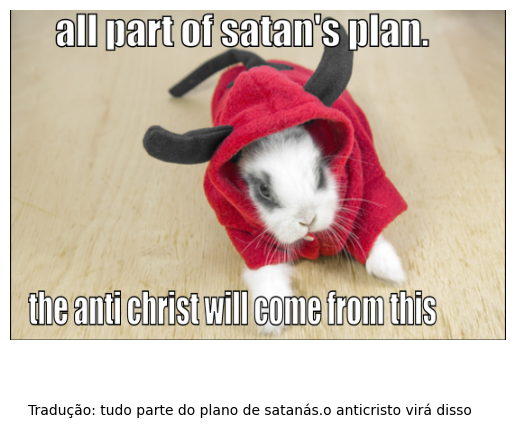

Imagem: img/52738.png
Rótulo verdadeiro: 0
Probabilidades: [isso é ódio: 0.5737 | isso não é ódio: 0.4263]
Predição do modelo: isso é ódio


In [ ]:
import torch
import clip
from PIL import Image
import json
import os
import random
import matplotlib.pyplot as plt
from googletrans import Translator

# load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# prepare the inputs
prompts = ["isso é ódio", "isso não é ódio"]
text_inputs = clip.tokenize(prompts).to(device)

# calculate features
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

def predict_meme_zero_shot(img_path):
    image = Image.open(img_path).convert("RGB")
    image_input = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_input)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # calculate similarity between image and text features
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

    # the similarity scores are probabilities.
    # similarity[0, 0] corresponds to the probability of "a hateful meme"
    # similarity[0, 1] corresponds to the probability of "a non-hateful meme"
    return similarity.cpu().numpy()[0]

base_path = '/content/model/hateful_memes/'
train_jsonl_path = os.path.join(base_path, "train.jsonl")

with open(train_jsonl_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

sample = json.loads(random.choice(lines))
img_path = os.path.join(base_path, sample["img"])

image = Image.open(img_path).convert("RGB")

translator = Translator()
text_en = sample.get("text", "")
text_pt = translator.translate(text_en, src="en", dest="pt").text if text_en else "(sem texto)"

plt.imshow(image)
plt.axis("off")
plt.figtext(0.5, -0.005, f"Tradução: {text_pt}",
            ha="center", fontsize=10, wrap=True)
plt.show()

probs = predict_meme_zero_shot(img_path)
predicted_label = prompts[probs.argmax()]

prob_str = " | ".join([f"{p}: {prob:.4f}" for p, prob in zip(prompts, probs)])

print(f"Imagem: {sample['img']}")
print(f"Rótulo verdadeiro: {sample.get('label', 'desconhecido')}")
print(f"Probabilidades: [{prob_str}]")
print(f"Predição do modelo: {predicted_label}")


## <font color="orange">4. Classificação</font>

Nesta etapa, o CLIP é avaliado em modo zero-shot, sem ajuste fino (fine-tuning), funcionando como baseline para comparação futura.

In [ ]:
from tqdm import tqdm

results = []
output_csv = os.path.join(base_path, "resultados_zero_shot.csv")

with open(train_jsonl_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

for line in tqdm(lines, desc="Processando imagens"):
    sample = json.loads(line)
    img_path = os.path.join(base_path, sample["img"])

    try:
        probs = predict_meme_zero_shot(img_path)
        predicted_label = prompts[probs.argmax()]

        results.append({
            "img": sample["img"],
            "text": sample.get("text", ""),
            "true_label": sample.get("label", "desconhecido"),
            "prob_ódio": float(probs[0]),
            "prob_não_ódio": float(probs[1]),
            "predição": predicted_label
        })
    except Exception as e:
        print(f"Erro com {sample['img']}: {e}")

df = pd.DataFrame(results)
df.to_csv(output_csv, index=False, encoding="utf-8")
print(f"\nResultados salvos em: {output_csv}")

Processando imagens: 100%|██████████| 8500/8500 [03:48<00:00, 37.27it/s]



Resultados salvos em: /content/model/hateful_memes/resultados_zero_shot.csv


## <font color="orange">5. Avaliação</font>

Nesta seção, são apresentados os resultados da avaliação do modelo utilizando o CLIP em configuração zero-shot. Para interpretar o desempenho obtido, são empregadas métricas amplamente utilizadas em tarefas de classificação supervisionada, como acurácia, precisão, revocação e F1-score, descritas a seguir.

**Acurácia**:
Mede a proporção total de acertos, ou seja, quantas previsões o modelo acertou em relação ao total de exemplos avaliados.

**Precisão** (Precision):
Indica que entre as amostras que o modelo previu como “ódio”, quantas realmente pertencem a essa classe.

Alta precisão significa poucos falsos positivos (erros ao classificar “não ódio” como “ódio”).

**Revocação** (Recall):
Mede entre os memes que realmente são “ódio”, quantos o modelo conseguiu identificar corretamente.

Alta revocação significa poucos falsos negativos (casos de ódio que o modelo deixou passar).

**F1-score**:
É a média harmônica entre precisão e revocação, equilibrando as duas métricas. É útil quando há diferença de desempenho entre as classes.

**Support**:
Mostra a quantidade de amostras de cada classe utilizadas no cálculo das métricas.

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

df_results = pd.read_csv(os.path.join(base_path, "resultados_zero_shot.csv"))
df_results["true_label"] = df_results["true_label"].astype(int)
df_results["pred_label"] = (df_results["predição"] == "isso é ódio").astype(int)

acc = accuracy_score(df_results["true_label"], df_results["pred_label"])
print(f"Acurácia zero-shot CLIP: {acc:.4f}")

print("\nRelatório de classificação:")
print(classification_report(df_results["true_label"], df_results["pred_label"],
                            target_names=["não ódio", "ódio"]))


Acurácia zero-shot CLIP: 0.4544

Relatório de classificação:
              precision    recall  f1-score   support

    não ódio       0.67      0.30      0.42      5481
        ódio       0.37      0.73      0.49      3019

    accuracy                           0.45      8500
   macro avg       0.52      0.52      0.45      8500
weighted avg       0.56      0.45      0.44      8500



A matriz de confusão permite visualizar o desempenho do modelo em termos de acertos e erros para cada classe.

Ela mostra quantas amostras de cada classe foram corretamente classificadas e quantas foram confundidas com a outra categoria, facilitando a identificação dos tipos de erro mais comuns.

- **Verdadeiros Positivos (True Positives - TP):** Memes que são de ódio (rótulo verdadeiro = 1) e foram corretamente classificados como ódio (predição = 1).
- **Verdadeiros Negativos (True Negatives - TN):** Memes que não são de ódio (rótulo verdadeiro = 0) e foram corretamente classificados como não ódio (predição = 0).
- **Falsos Positivos (False Positives - FP):** Memes que não são de ódio (rótulo verdadeiro = 0) mas foram classificados incorretamente como ódio (predição = 1).
- **Falsos Negativos (False Negatives - FN):** Memes que são de ódio (rótulo verdadeiro = 1) mas foram classificados incorretamente como não ódio (predição = 0).

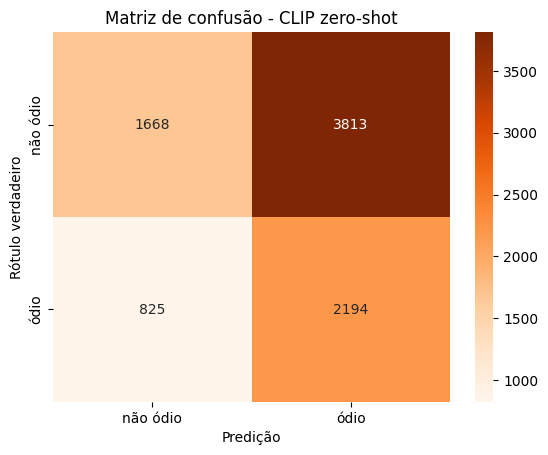

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(df_results["true_label"], df_results["pred_label"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
            xticklabels=["não ódio", "ódio"],
            yticklabels=["não ódio", "ódio"])
plt.xlabel("Predição")
plt.ylabel("Rótulo verdadeiro")
plt.title("Matriz de confusão - CLIP zero-shot")
plt.show()

A matriz de confusão indica que o modelo tende a classificar uma grande quantidade de exemplos como “ódio”, mesmo quando o rótulo verdadeiro é “não ódio”. Isso indica um viés para a classe “ódio”, com muitos falsos positivos (3813 casos).

Por outro lado, ele ainda acerta uma parte significativa dos memes realmente odiosos (2194 acertos contra 825 erros), o que mostra uma boa capacidade de detecção, embora com baixo equilíbrio entre as classes.

A seguir, são mostrados exemplos de acertos e erros do modelo, permitindo uma análise visual do comportamento do CLIP. Essa etapa ajuda a entender em quais situações o modelo acerta e onde tende a confundir as classes.

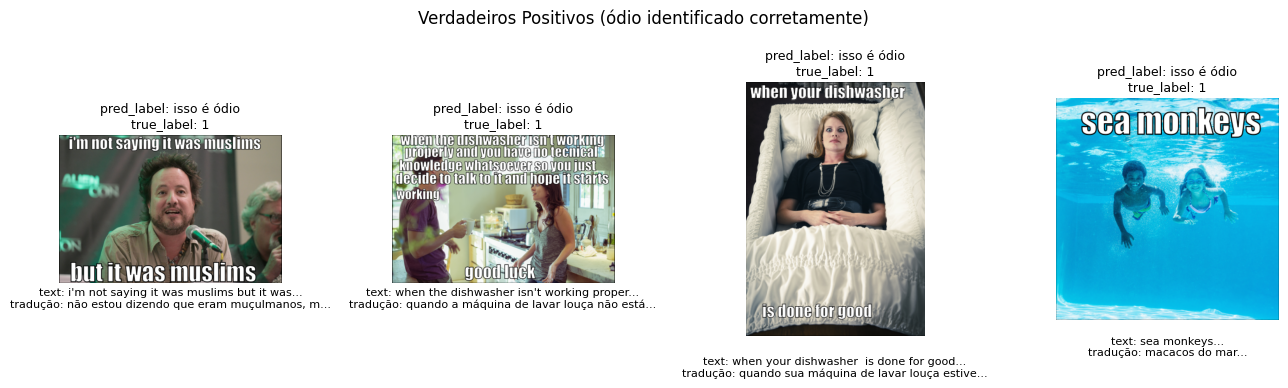

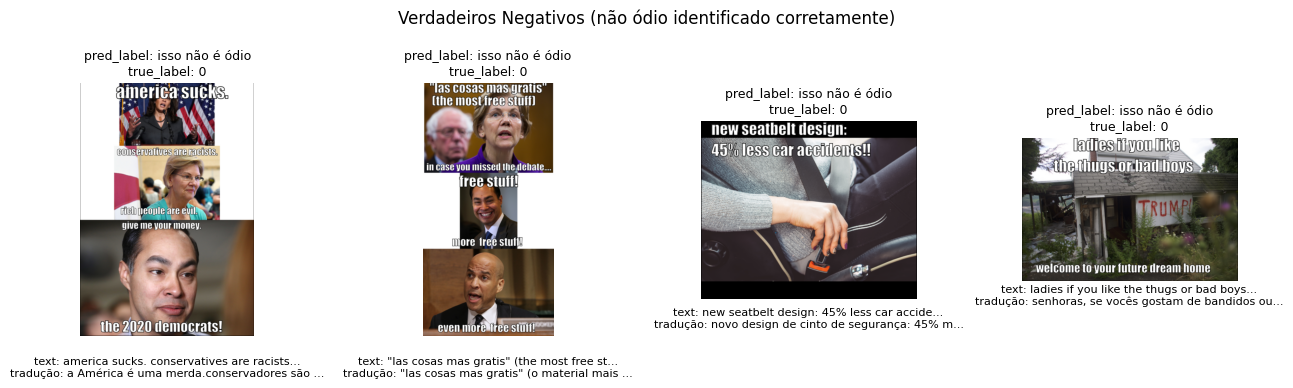

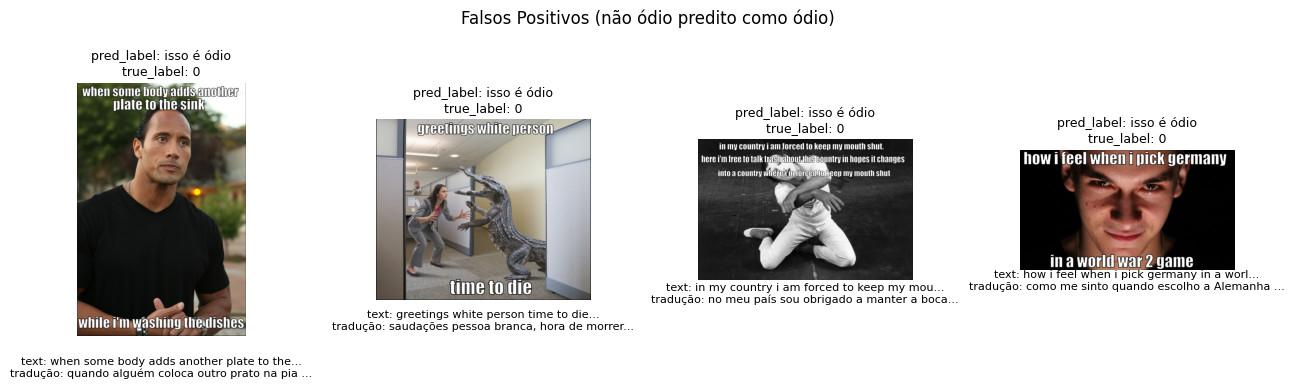

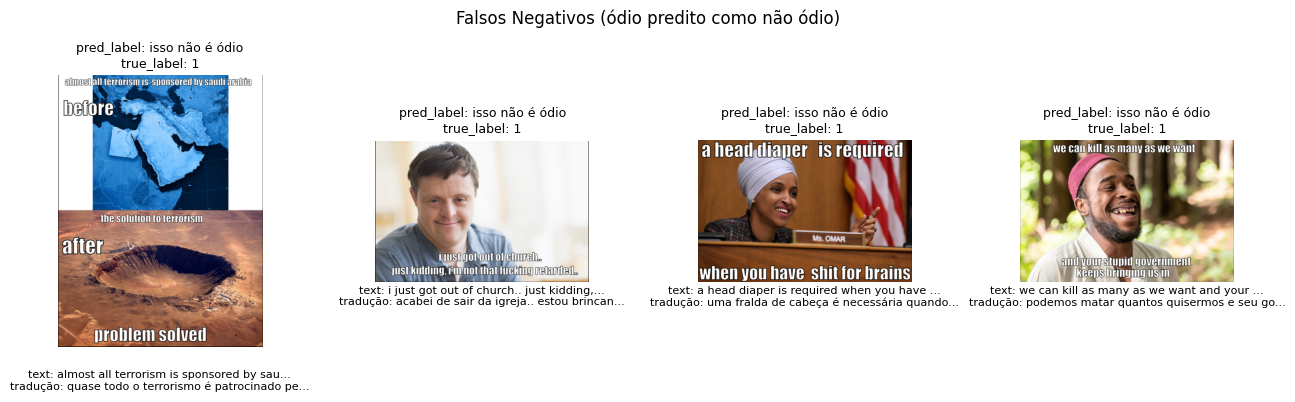

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
from googletrans import Translator

translator = Translator()

df_results["acertou"] = df_results["true_label"] == df_results["pred_label"]

true_positive = df_results[(df_results["true_label"] == 1) & (df_results["pred_label"] == 1)]
true_negative = df_results[(df_results["true_label"] == 0) & (df_results["pred_label"] == 0)]
false_positive = df_results[(df_results["true_label"] == 0) & (df_results["pred_label"] == 1)]
false_negative = df_results[(df_results["true_label"] == 1) & (df_results["pred_label"] == 0)]

def mostrar_exemplos(df, titulo, n=4):
    amostras = df.sample(min(n, len(df)))
    plt.figure(figsize=(13, 4))

    for i, row in enumerate(amostras.itertuples(), 1):
        img_path = os.path.join(base_path, row.img)
        try:
            img = Image.open(img_path).convert("RGB")

            traducao = translator.translate(row.text, src='en', dest='pt').text

            plt.subplot(1, n, i)
            plt.imshow(img)
            plt.axis("off")

            plt.title(f"pred_label: {row.predição}\ntrue_label: {row.true_label}", fontsize=9)
            plt.text(
                0.5, -0.15,
                f"text: {row.text[:40]}...\ntradução: {traducao[:40]}...",
                fontsize=8,
                wrap=True,
                ha="center",
                transform=plt.gca().transAxes
            )

        except Exception as e:
            print(f"Erro ao abrir {row.img}: {e}")

    plt.suptitle(titulo, fontsize=12)
    plt.tight_layout()
    plt.show()


mostrar_exemplos(true_positive, "Verdadeiros Positivos (ódio identificado corretamente)")
mostrar_exemplos(true_negative, "Verdadeiros Negativos (não ódio identificado corretamente)")
mostrar_exemplos(false_positive, "Falsos Positivos (não ódio predito como ódio)")
mostrar_exemplos(false_negative, "Falsos Negativos (ódio predito como não ódio)")

## <font color="orange">6. Conclusão</font>

Nesse primeiro teste, o modelo CLIP em modo zero-shot, utilizando os prompts "isso é ódio" e "isso não é ódio", apresentou um desempenho inicial com uma acurácia de **0.4544**.

Ao analisar a avaliação do modelo, observa-se um viés significativo para a classe “ódio”, classificando incorretamente muitas amostras de “não ódio” como “ódio” (muitos falsos positivos).

Apesar disso, o modelo conseguiu identificar uma proporção considerável de memes realmente odiosos, indicando boa sensibilidade, ainda que acompanhada de uma taxa alta de falsos positivos.

Esse comportamento reforça a importância de abordagens complementares, como um pré-tratamento das labels de classificação, considerando a composição do conjunto de dados: 40% de memes de ódio multimodal (texto e imagem), 10% de memes de ódio unimodal (apenas texto ou imagem), 20% de confundidores benignos de texto, 20% de confundidores benignos de imagem e 10% de memes não odiosos aleatórios.

Devido a essa distribuição, é possível que o modelo tenha se tornado mais propenso a identificar discurso de ódio quando ele está explicitamente presente, mas apresenta um desempenho inferior ao lidar com os confundidores benignos, nos quais a relação entre texto e imagem exige uma análise mais contextual.

Esse comportamento reforça a importância de abordagens complementares e a necessidade de experimentos futuros, como:

*   **Ajuste Fino (Fine-tuning):** Treinar o modelo CLIP em uma porção do dataset Hateful Memes para adaptar suas representações ao domínio específico de memes odiosos.

*   **Exploração de Prompts:** Experimentar diferentes prompts e formatos de prompt para a classificação zero-shot, buscando formulações que melhor capturem a distinção entre ódio e não ódio no contexto dos memes.

*   **Análise de Erros:** Investigar mais a fundo os casos de falsos positivos e falsos negativos para entender quais características visuais ou textuais estão levando o modelo a cometer esses erros.

*   **Bootstrapping:** Aplicar técnicas de reamostragem para gerar múltiplos subconjuntos do dataset, permitindo estimar a incerteza do modelo, identificar características mais relevantes e reduzir o risco de *overfitting* (quando o modelo aprende detalhes específicos do treino apenas memorizando, em vez de capturar padrões gerais), contribuindo para modelos mais robustos e precisos.

Em resumo, este experimento zero-shot serve como uma linha de base inicial, demonstrando a capacidade do CLIP em realizar a tarefa de classificação de ódio em memes mesmo sem treinamento específico, mas também evidenciando as limitações dessa abordagem e a necessidade de otimizações futuras para melhorar o equilíbrio e a acurácia da classificação.